In [46]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler


pandas.set_option("display.precision", 2)

datafile = '../../Data/Raw/airbnb/airbnb_queens_2019.csv'

input_table = '../../Data/Processed/airbnb/airbnb.parquet'


target_outlier = True
feature_outlier= True
feature_norm   = True
target_norm    = False

test_var = 'number_of_reviews'

target_variable = ['price']

info_variables = ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group','last_review',]
# categorical_variables = ['room_type','neighbourhood',]
categorical_variables = []

numeric_variables = ['latitude', 'longitude', 'minimum_nights',
                       'number_of_reviews',  'reviews_per_month', 'calculated_host_listings_count',
                       'availability_365']

# Load Data 

In [47]:
data = pandas.read_parquet(input_table)
print('data shape:', data.shape)
print('data columns:', data.columns.tolist())
data.head()

data shape: (5666, 16)
data columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12937,"1 Stop fr. Manhattan! Private Suite,Landmark B...",50124,Orestes,Queens,Long Island City,40.75,-73.95,Private room,130.0,3.0,248.0,2019-07-01,2.25,1.0,215.0
1,18198,Little King of Queens,70091,Justin,Queens,Woodside,40.75,-73.90,Private room,70.0,30.0,25.0,2019-05-31,0.22,1.0,324.0
2,32363,Fully Furnished Basement Apartment,140025,Fredah,Queens,Flushing,40.74,-73.83,Private room,140.0,2.0,1.0,2011-09-19,0.01,1.0,1.0
3,39593,"A room w/ a Manhattan view, longer stay",110506,Myung,Queens,Sunnyside,40.75,-73.92,Private room,79.0,30.0,28.0,2019-04-12,0.26,1.0,126.0
4,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,Queens,Ridgewood,40.70,-73.90,Entire home/apt,350.0,8.0,10.0,2019-05-12,0.11,5.0,365.0


# Outlier 

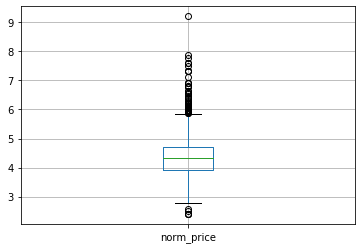

In [48]:
data['norm_price'] = np.log1p(data[target_variable])
data.boxplot('norm_price')

In [49]:
if target_outlier:
    print('data before:', data.shape)
    data = data[(data.norm_price>3) & (data.norm_price<6)].copy()
    print('data after:', data.shape)
    data.drop('norm_price', axis=1, inplace=True)

data before: (5666, 17)
data after: (5601, 17)


# Preencher Valores Nulos

In [50]:
for cname in ['number_of_reviews', 'reviews_per_month']:
    data[cname].fillna(0, inplace=True)

# Normalização de Variáveis

In [51]:
if feature_norm:
    log_norm_cols = ['minimum_nights', 'number_of_reviews', 
                     'reviews_per_month', 'calculated_host_listings_count','availability_365']

    data[log_norm_cols] = preprocessing.power_transform(data[log_norm_cols], method='yeo-johnson')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E3509CB3C8>]],
      dtype=object)

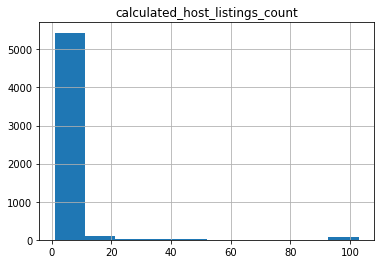

In [42]:
data.hist(['calculated_host_listings_count'])

# Remoção Outlier Variáveis

In [52]:
if feature_outlier:
    for cname in numeric_variables:
        lo_lim = np.quantile(data[cname], 0.10)
        up_lim = np.quantile(data[cname], 0.90)
        data.loc[data[cname] < lo_lim, cname] = lo_lim
        data.loc[data[cname] > up_lim, cname] = up_lim

# Normalizando o Alvo 

In [53]:
if target_norm:
    data[target_variable] = np.log1p(data[target_variable])

# Codificando Variaveis 

In [54]:
if len(categorical_variables):
    cat_data = pandas.get_dummies(data[categorical_variables])
    train_data = pandas.concat((data.drop(categorical_variables,axis=1), cat_data), axis=1, sort=False)
    train_data.drop(info_variables, axis=1, inplace=True)
else:
    train_data = data[numeric_variables+target_variable]

# Pipeline de Treinamento 

In [55]:

# Configure Pipeline
conf_train_pipe = [
    ('Scaler', StandardScaler()),
    ('Model', lm.LinearRegression()),
]

# Create Pipeline
model_pipe = pipeline.Pipeline(conf_train_pipe)

# Train Pipeline
X = train_data.drop(target_variable, axis=1).values
Y = train_data[target_variable].values

model_pipe.fit(X, Y)

Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('Model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

## Estimativa do Modelo 

In [56]:
Yhat = model_pipe.predict(X)

if target_norm:
    Yhat = np.expm1(Yhat)
    Y = np.expm1(Y)
else:
    Yhat[Yhat<0] = 0


print('Yhat.shape:', Yhat.shape)

Yhat.shape: (5601, 1)


In [45]:
print(Yhat)

[[105.95823801]
 [113.24375256]
 [ 93.88240823]
 ...
 [107.84727372]
 [ 80.86604481]
 [ 86.27861406]]


# Distribuições 

No handles with labels found to put in legend.


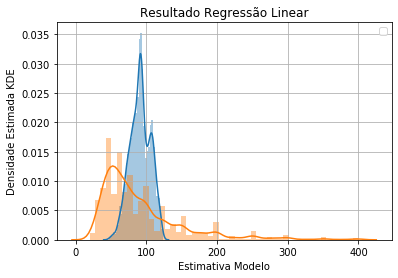

In [58]:
plt.figure()
# idx = Y < 1000
sns.distplot(Yhat)
sns.distplot(Y)
plt.title('Resultado Regressão Linear')
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Estimativa Modelo')
plt.grid()
plt.legend()

# Scatter Plot 

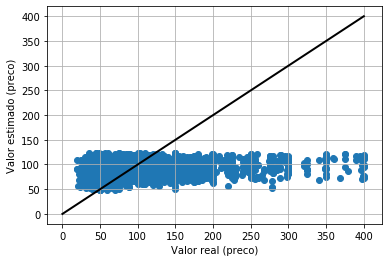

In [59]:
plt.figure()

plt.plot([0, Y.max()], [0, Y.max()], '-k',lw=2,label='Linha Ideal')
plt.scatter(Y, Yhat, label='Regressão linear')
plt.xlabel('Valor real (preco)')
plt.ylabel('Valor estimado (preco)')
plt.grid()

# Plot de Resíduo 

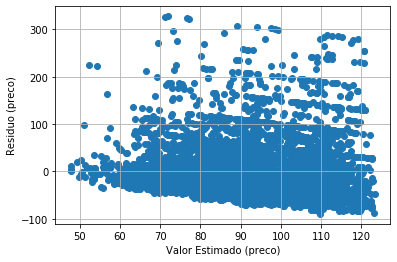

In [60]:
plt.figure()
plt.scatter(Yhat, Y - Yhat, label='Regressão linear')
plt.xlabel('Valor Estimado (preco)')
plt.ylabel('Residuo (preco)')
plt.grid()

# Metrics

In [61]:
def mape(y, yhat):
  idx = y != 0
  return np.mean(np.abs((y[idx]-yhat[idx])/ y[idx])) * 100


print('r2  :', metrics.r2_score(Y, Yhat))
print('mse :', metrics.mean_squared_error(Y, Yhat))
print('msle:', metrics.mean_squared_log_error(Y, Yhat))
print('mae :', metrics.mean_absolute_error(Y, Yhat))
print('mape:', mape(Y, Yhat))



r2  : 0.05912549054553751
mse : 3274.7649711985655
msle: 0.29140673909357667
mae : 40.714952518580475
mape: 53.90958914604743
